## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [5]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 16 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [9]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [10]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [11]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [12]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [13]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [14]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [15]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [16]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [17]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [18]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [19]:
train_dataset[0][0].shape

torch.Size([16, 224, 224])

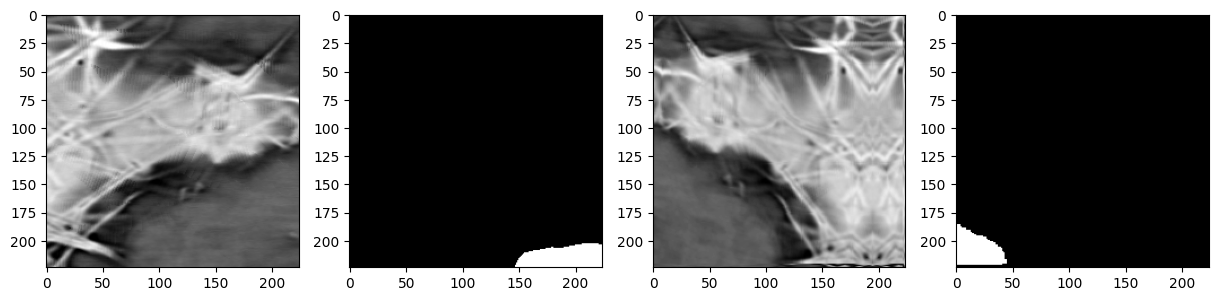

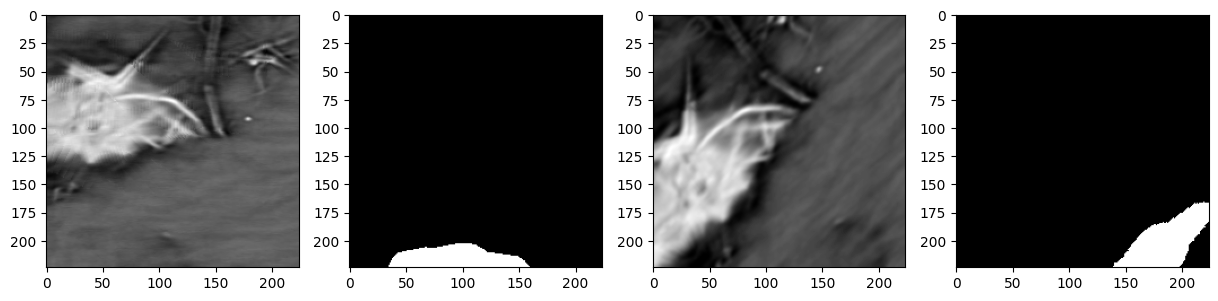

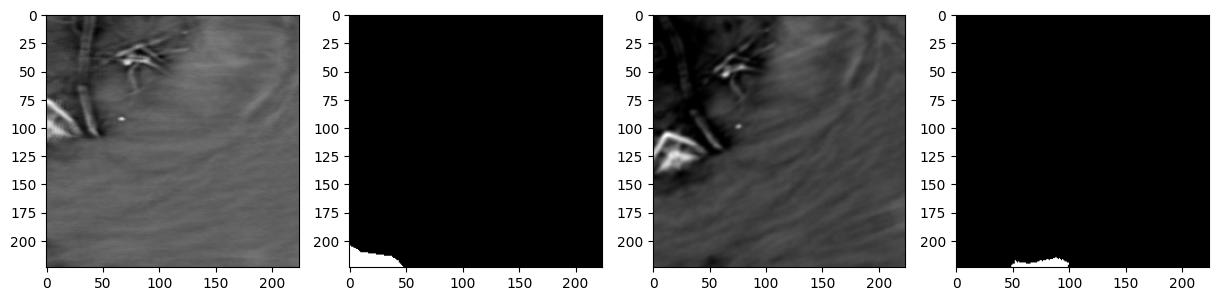

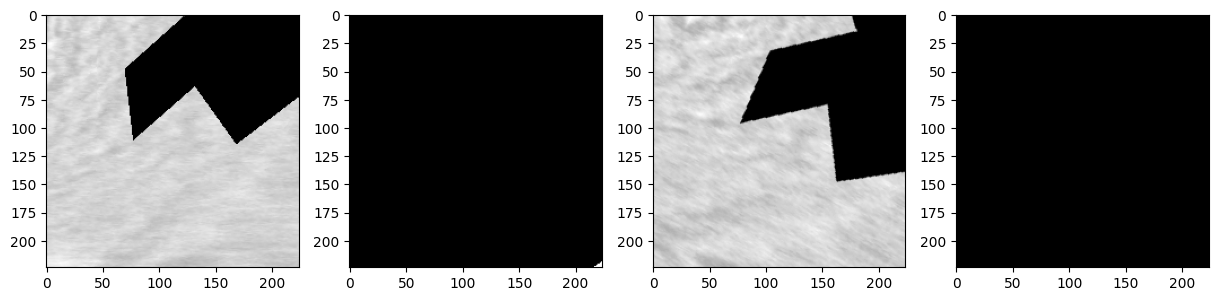

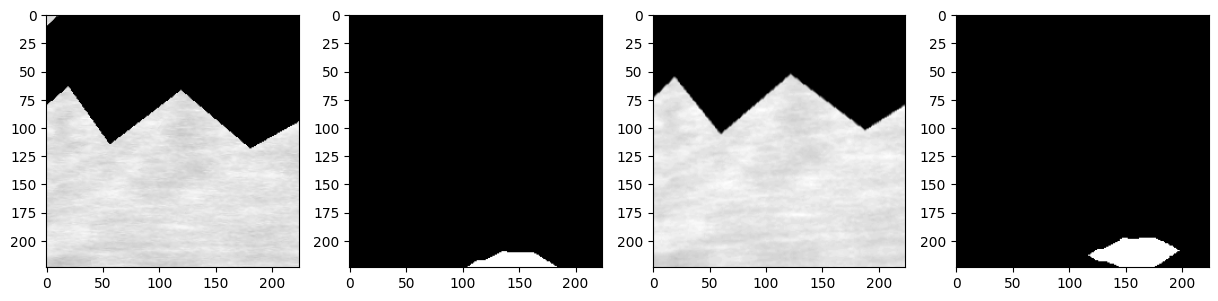

In [20]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [21]:
del plot_dataset
gc.collect()

53836

## model

In [22]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [23]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [24]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [25]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    return bce_loss
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [26]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [27]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [28]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [29]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1209852827833084
th: 0.15, fbeta: 0.12152032153671674
th: 0.2, fbeta: 0.20700024801289144
th: 0.25, fbeta: 0.215157094358992
th: 0.3, fbeta: 0.22428704638715052
th: 0.35, fbeta: 0.22804021159958437
th: 0.4, fbeta: 0.2232566400004115
th: 0.45, fbeta: 0.20297701430524048


best_th: 0.35, fbeta: 0.22804021159958437
Epoch 1 - avg_train_loss: 0.5962  avg_val_loss: 0.4122  time: 36s
Epoch 1 - avgScore: 0.2280
Epoch 1 - Save Best Score: 0.2280 Model
Epoch 1 - Save Best Loss: 0.4122 Model


th: 0.5, fbeta: 0.13944549559246044


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21184871309184772
th: 0.15, fbeta: 0.22534621588117115
th: 0.2, fbeta: 0.23783433901259016
th: 0.25, fbeta: 0.25033464307982084
th: 0.3, fbeta: 0.2519122829317276
th: 0.35, fbeta: 0.22207326443313413
th: 0.4, fbeta: 0.12729067314997713
th: 0.45, fbeta: 0.02267859457888523


best_th: 0.3, fbeta: 0.2519122829317276
Epoch 2 - avg_train_loss: 0.3901  avg_val_loss: 0.3116  time: 62s
Epoch 2 - avgScore: 0.2519
Epoch 2 - Save Best Score: 0.2519 Model
Epoch 2 - Save Best Loss: 0.3116 Model


th: 0.5, fbeta: 0.0011346823657941648


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.2674720181319054
th: 0.15, fbeta: 0.29559576380615865
th: 0.2, fbeta: 0.3247163825550875
th: 0.25, fbeta: 0.35921331141049995
th: 0.3, fbeta: 0.39587159815432504
th: 0.35, fbeta: 0.3967648749170788
th: 0.4, fbeta: 0.27365727318027966
th: 0.45, fbeta: 0.058919885243301065


best_th: 0.35, fbeta: 0.3967648749170788
Epoch 3 - avg_train_loss: 0.2905  avg_val_loss: 0.2425  time: 35s
Epoch 3 - avgScore: 0.3968
Epoch 3 - Save Best Score: 0.3968 Model
Epoch 3 - Save Best Loss: 0.2425 Model


th: 0.5, fbeta: 1.6854994891162453e-05


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26120590415371014
th: 0.15, fbeta: 0.29729379529549677
th: 0.2, fbeta: 0.33160653196219275
th: 0.25, fbeta: 0.3605925547512499
th: 0.3, fbeta: 0.3842987878932922
th: 0.35, fbeta: 0.4018110783895324
th: 0.4, fbeta: 0.4133335135221034
th: 0.45, fbeta: 0.4141552408954973


best_th: 0.45, fbeta: 0.4141552408954973
Epoch 4 - avg_train_loss: 0.2614  avg_val_loss: 0.2473  time: 35s
Epoch 4 - avgScore: 0.4142
Epoch 4 - Save Best Score: 0.4142 Model
Epoch 4 - Save Best Loss: 0.2473 Model


th: 0.5, fbeta: 0.33992538113393106


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2674960404085553
th: 0.15, fbeta: 0.305379640625388
th: 0.2, fbeta: 0.3424709282978609
th: 0.25, fbeta: 0.3771928803761744
th: 0.3, fbeta: 0.4052239867658304
th: 0.35, fbeta: 0.42783627880650293
th: 0.4, fbeta: 0.44472013530601745
th: 0.45, fbeta: 0.4556069217638955


best_th: 0.5, fbeta: 0.46491128176297813
Epoch 5 - avg_train_loss: 0.2527  avg_val_loss: 0.2421  time: 35s
Epoch 5 - avgScore: 0.4649
Epoch 5 - Save Best Score: 0.4649 Model
Epoch 5 - Save Best Loss: 0.2421 Model


th: 0.5, fbeta: 0.46491128176297813


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30674436978736663
th: 0.15, fbeta: 0.36726681779387343
th: 0.2, fbeta: 0.4064411460037463
th: 0.25, fbeta: 0.4349945962782986
th: 0.3, fbeta: 0.4533674799898882
th: 0.35, fbeta: 0.4641666818958052
th: 0.4, fbeta: 0.47057281248240324
th: 0.45, fbeta: 0.47233234704970883


best_th: 0.45, fbeta: 0.47233234704970883
Epoch 6 - avg_train_loss: 0.2446  avg_val_loss: 0.2377  time: 36s
Epoch 6 - avgScore: 0.4723
Epoch 6 - Save Best Score: 0.4723 Model
Epoch 6 - Save Best Loss: 0.2377 Model


th: 0.5, fbeta: 0.46264438571038596


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35353925567167976
th: 0.15, fbeta: 0.41529809463143613
th: 0.2, fbeta: 0.4690872094004237
th: 0.25, fbeta: 0.5014661836395504
th: 0.3, fbeta: 0.5128688212373488
th: 0.35, fbeta: 0.5054904703157296
th: 0.4, fbeta: 0.4848912844885648
th: 0.45, fbeta: 0.45030681538681205


best_th: 0.3, fbeta: 0.5128688212373488
Epoch 7 - avg_train_loss: 0.2374  avg_val_loss: 0.2363  time: 36s
Epoch 7 - avgScore: 0.5129
Epoch 7 - Save Best Score: 0.5129 Model
Epoch 7 - Save Best Loss: 0.2363 Model


th: 0.5, fbeta: 0.4004010318673991


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3430675445592204
th: 0.15, fbeta: 0.3948617916430507
th: 0.2, fbeta: 0.44136901255900873
th: 0.25, fbeta: 0.4689797533969692
th: 0.3, fbeta: 0.48088175450105236
th: 0.35, fbeta: 0.4846948804264627
th: 0.4, fbeta: 0.4788093556004102
th: 0.45, fbeta: 0.4666325059145363


best_th: 0.35, fbeta: 0.4846948804264627
Epoch 8 - avg_train_loss: 0.2313  avg_val_loss: 0.2406  time: 36s
Epoch 8 - avgScore: 0.4847


th: 0.5, fbeta: 0.44729213266789425


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3768322437688364
th: 0.15, fbeta: 0.4237777465939117
th: 0.2, fbeta: 0.4571357318328052
th: 0.25, fbeta: 0.4810238432352214
th: 0.3, fbeta: 0.49657479955491673
th: 0.35, fbeta: 0.503795219778237
th: 0.4, fbeta: 0.5020940816203806
th: 0.45, fbeta: 0.49656703482500925


best_th: 0.35, fbeta: 0.503795219778237
Epoch 9 - avg_train_loss: 0.2266  avg_val_loss: 0.2446  time: 35s
Epoch 9 - avgScore: 0.5038


th: 0.5, fbeta: 0.484638636081468


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36722890452147744
th: 0.15, fbeta: 0.41451929556064215
th: 0.2, fbeta: 0.44628795317475384
th: 0.25, fbeta: 0.4699696413515231
th: 0.3, fbeta: 0.48951168875340473
th: 0.35, fbeta: 0.5022857250704916
th: 0.4, fbeta: 0.5097529196295276
th: 0.45, fbeta: 0.5106017235429174


best_th: 0.45, fbeta: 0.5106017235429174
Epoch 10 - avg_train_loss: 0.2183  avg_val_loss: 0.2349  time: 35s
Epoch 10 - avgScore: 0.5106


th: 0.5, fbeta: 0.501956682779878


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32831836124421215
th: 0.15, fbeta: 0.3654765997133357
th: 0.2, fbeta: 0.39425889283370247
th: 0.25, fbeta: 0.4213804644486175
th: 0.3, fbeta: 0.4452516941551013
th: 0.35, fbeta: 0.4651844434891123
th: 0.4, fbeta: 0.48357980574910486
th: 0.45, fbeta: 0.49831491919836624


best_th: 0.5, fbeta: 0.5031400143202076
Epoch 11 - avg_train_loss: 0.2119  avg_val_loss: 0.2391  time: 35s
Epoch 11 - avgScore: 0.5031


th: 0.5, fbeta: 0.5031400143202076


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37215993004874676
th: 0.15, fbeta: 0.41969070972252476
th: 0.2, fbeta: 0.4519390359523037
th: 0.25, fbeta: 0.4747194085304907
th: 0.3, fbeta: 0.4902260071464067
th: 0.35, fbeta: 0.4962229409341746
th: 0.4, fbeta: 0.49529512789290925
th: 0.45, fbeta: 0.4851644681038352


best_th: 0.35, fbeta: 0.4962229409341746
Epoch 12 - avg_train_loss: 0.2086  avg_val_loss: 0.2382  time: 35s
Epoch 12 - avgScore: 0.4962


th: 0.5, fbeta: 0.4647020166641522


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33836866831523194
th: 0.15, fbeta: 0.3777137954831446
th: 0.2, fbeta: 0.4118198453222626
th: 0.25, fbeta: 0.4427857184596864
th: 0.3, fbeta: 0.4673627915576412
th: 0.35, fbeta: 0.48258756704436656
th: 0.4, fbeta: 0.49479029310467654
th: 0.45, fbeta: 0.5038609010547187


best_th: 0.45, fbeta: 0.5038609010547187
Epoch 13 - avg_train_loss: 0.2071  avg_val_loss: 0.2355  time: 35s
Epoch 13 - avgScore: 0.5039


th: 0.5, fbeta: 0.4998324241772303


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3546498130682871
th: 0.15, fbeta: 0.39630210055260123
th: 0.2, fbeta: 0.42896310311257474
th: 0.25, fbeta: 0.45222961261804817
th: 0.3, fbeta: 0.4708715416600127
th: 0.35, fbeta: 0.48669071454862567
th: 0.4, fbeta: 0.49731800932149983
th: 0.45, fbeta: 0.49663685973904154


best_th: 0.4, fbeta: 0.49731800932149983
Epoch 14 - avg_train_loss: 0.2009  avg_val_loss: 0.2371  time: 35s
Epoch 14 - avgScore: 0.4973


th: 0.5, fbeta: 0.48290038291513876


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36420992069632824
th: 0.15, fbeta: 0.41010475536621005
th: 0.2, fbeta: 0.44568259880038774
th: 0.25, fbeta: 0.47103241300345294
th: 0.3, fbeta: 0.4895285286492174
th: 0.35, fbeta: 0.4999902549403792
th: 0.4, fbeta: 0.5035874687414363
th: 0.45, fbeta: 0.4981212332183891


best_th: 0.4, fbeta: 0.5035874687414363
Epoch 15 - avg_train_loss: 0.1988  avg_val_loss: 0.2380  time: 35s
Epoch 15 - avgScore: 0.5036


th: 0.5, fbeta: 0.4820489278410121


In [30]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [31]:
mask_pred = check_point['preds']

In [32]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.35353925567167976
th: 0.15, fbeta: 0.41529809463143613
th: 0.2, fbeta: 0.4690872094004237
th: 0.25, fbeta: 0.5014661836395504
th: 0.3, fbeta: 0.5128688212373488
th: 0.35, fbeta: 0.5054904703157296
th: 0.4, fbeta: 0.4848912844885648
th: 0.45, fbeta: 0.45030681538681205


best_th: 0.3, fbeta: 0.5128688212373488


th: 0.5, fbeta: 0.4004010318673991


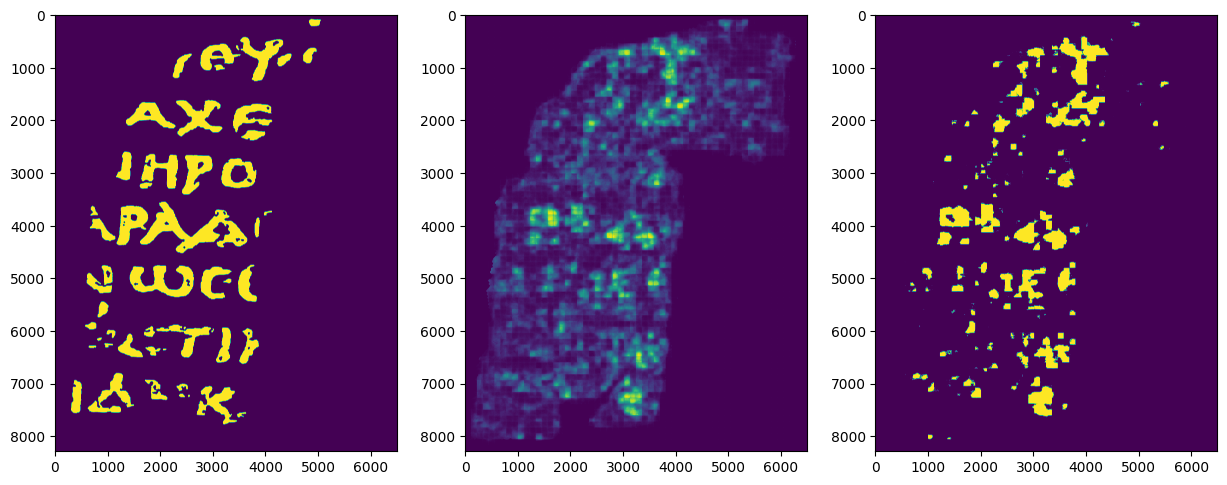

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([3.2263224e+07, 6.9460320e+06, 4.4203970e+06, 2.9118180e+06,
        1.9557350e+06, 1.3181600e+06, 9.4131400e+05, 6.8249200e+05,
        4.9802100e+05, 3.9839500e+05, 3.4144700e+05, 2.7143100e+05,
        2.1983200e+05, 1.8343100e+05, 1.4997500e+05, 1.1702900e+05,
        8.9384000e+04, 7.0088000e+04, 4.1569000e+04, 1.9074000e+04]),
 array([1.35679734e-05, 4.30280150e-02, 8.60424620e-02, 1.29056909e-01,
        1.72071356e-01, 2.15085803e-01, 2.58100250e-01, 3.01114697e-01,
        3.44129144e-01, 3.87143591e-01, 4.30158038e-01, 4.73172485e-01,
        5.16186932e-01, 5.59201379e-01, 6.02215826e-01, 6.45230273e-01,
        6.88244720e-01, 7.31259167e-01, 7.74273614e-01, 8.17288061e-01,
        8.60302508e-01]),
 <BarContainer object of 20 artists>)

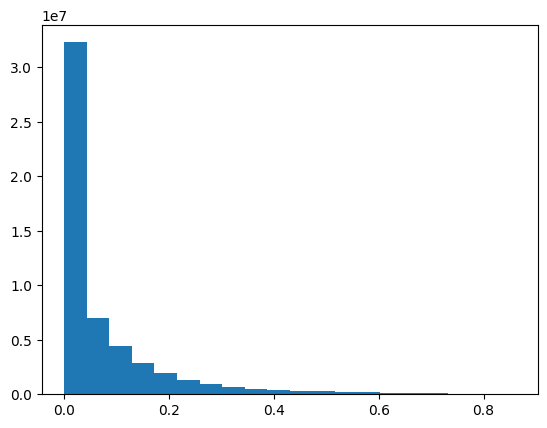

In [34]:
plt.hist(mask_pred.flatten(), bins=20)